<a href="https://colab.research.google.com/github/mas0ny1/COMP6733-Project/blob/main/final_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9). 

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

In [ ]:
print("Please wait for ~8 seconds for the GPU session initialization. \n \
==> Please select both images at the same time after clicking \"Choose Files\".")
!mkdir -p /content/uploaded/ && rm -rf /content/uploaded/* # clear previously uploaded images
%cd /content/uploaded/
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=file_name, length=len(uploaded[file_name])))
image_pair = ['/content/uploaded/' + f for f in list(uploaded.keys())]
%cd ..

# Change the image type here.
image_type = 'indoor'
# image_type = 'outdoor'

Please wait for ~8 seconds for the GPU session initialization. 
 ==> Please select both images at the same time after clicking "Choose Files".
/content/uploaded


Saving L16_10am.JPG to L16_10am (1).JPG
User uploaded file "L16_10am.JPG" with length 8609390 bytes
/content


You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [24]:
# knn matching algorithm without machine learning
# Written by Cameron McGowan (z5361406)

import json

def open_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
      
def match(database, fingerprint):
    finger_size = len(database)
    if finger_size == 2:
        finger_size = 1
    matches = list()
    for loc, sample in database.items():
        dist = 0.0
        count = 0
        for ssid_mac, rssi in sample.items():
            if ssid_mac in fingerprint.keys():
                dist += pow(abs(abs(rssi) - abs(fingerprint[ssid_mac])), 2)
                count += 1
        if count > finger_size / 2:
            matches.append(tuple((dist / count, loc)))
    matches.sort()
    return matches   


# Returns true if top floor, else bottom floor
def localise(matches):
    k = 5
    length = len(matches)
    length = min(length, k)
    if length > 0 and length % 2 == 0:
        length -= 1
    floor3 = 0
    floor2 = 0
    for i in range(length):
        if int(matches[i][1].split("_")[1]) <= 15:
            floor3 += 1
        else:
            floor2 += 1
    return floor3 > floor2

database = open_json_file("/content/uploaded/fingerprint_dataset.json")
fingerprints = open_json_file("/content/uploaded/test.json")
correct = 0
count = 0
k = 5

for loc, fingerprint in fingerprints.items():
    matches = match(database, fingerprint)
    possible_locations = []
    length = len(matches)
    length = min(length, k)
    if length > 0 and length % 2 == 0:
        length -= 1
    floor3 = 0
    floor2 = 0
    for i in range(length):
        print(matches[i][1])
        possible_locations.append(matches[i][1].split("_")[1])
        if int(matches[i][1].split("_")[1]) <= 15:
            floor3 += 1
        else:
            floor2 += 1
        # if matches[i][1] == loc:
        #     correct += 1
        #     break
    if floor3 > floor2 and int(loc.split("_")[1]) <= 15 or floor3 < floor2 and int(loc.split("_")[1]) > 15:
        #correct += 1
        pass
    count += 1
print("possible locations:")    
print(possible_locations)

    
    

        
    
    

location_2
location_1
location_3
location_4
location_5
possible locations:
['2', '1', '3', '4', '5']


location:2, maching score:690
location:1, maching score:182
location:3, maching score:250
location:4, maching score:174
location:5, maching score:176
You are at location: 2


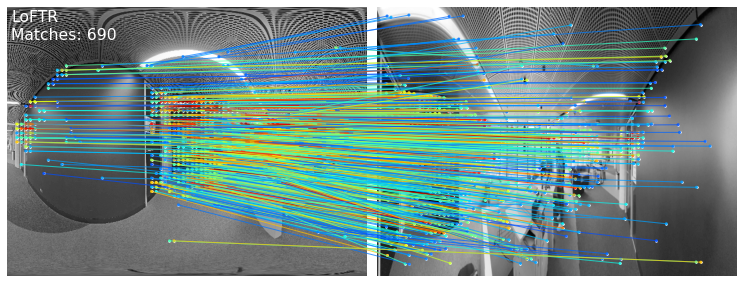

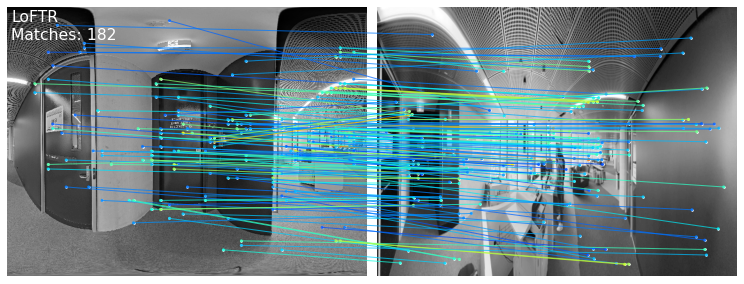

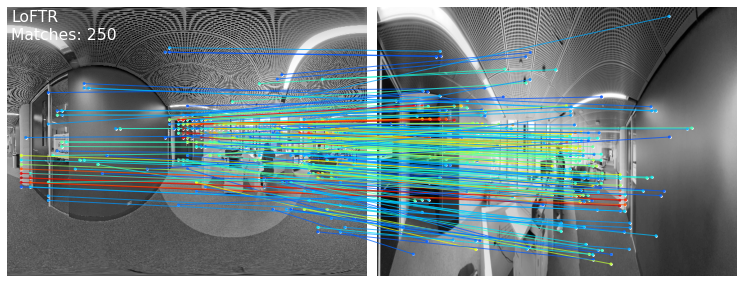

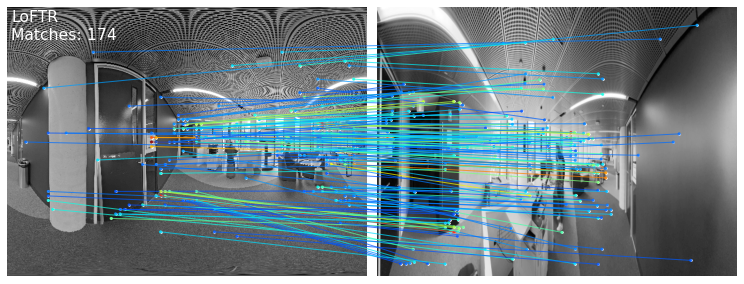

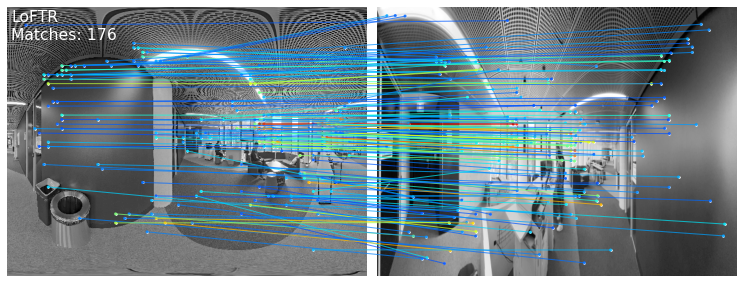

In [25]:
# Configure environment and grab LoFTR code.
# !rm -rf sample_data
# !pip install torch einops yacs kornia
# !git clone https://github.com/zju3dv/LoFTR --depth 1
# !mv LoFTR/* . && rm -rf LoFTR

# # Download pretrained weights
# !mkdir weights 
# %cd weights/
# !gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
# !gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
# %cd ..

# import torch
# import cv2
# import numpy as np
# import matplotlib.cm as cm

# from src.utils.plotting import make_matching_figure
# from src.loftr import LoFTR, default_cfg

matcher = LoFTR(config=default_cfg)
image_type = 'outdoor'
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

# for location in range(16, 31):
#   matches = []
location = 0
match_score = 0
img0_pth = f"/content/uploaded/L2_test.jpg"
for i in possible_locations:
  img1_pth = f"/content/uploaded/L{i}_10am.JPG"
  image_pair = [img0_pth, img1_pth]
  image_pair = [img1_pth, img0_pth]

  # Rerun this cell (and below) if a new image pair is uploaded.
  img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
  img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
  img0_raw = cv2.resize(img0_raw, (640, 480))
  img1_raw = cv2.resize(img1_raw, (640, 480))

  img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
  img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
  batch = {'image0': img0, 'image1': img1}

  # Inference with LoFTR and get prediction
  with torch.no_grad():
      matcher(batch)
      mkpts0 = batch['mkpts0_f'].cpu().numpy()
      mkpts1 = batch['mkpts1_f'].cpu().numpy()
      mconf = batch['mconf'].cpu().numpy()

  color = cm.jet(mconf, alpha=0.7)
  text = [
      'LoFTR',
      'Matches: {}'.format(len(mkpts0)),
  ]
  # matches.append(len(mkpts0))
  fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)
  # print(len(mkpts0))
  # A high-res PDF will also be downloaded automatically.
  # make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path=f"LoFTR-Location-{i}.pdf")
  # files.download(f"LoFTR-Location-{i}.pdf")
  if len(mkpts0) > match_score:
    location = i
    match_score = len(mkpts0)
  print(f"location:{i}, maching score:{len(mkpts0)}")


print(f"You are at location: {location}")
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')